One of the most obvious features of the data presented in the [previous article](/posts/medalla-validator-taxonomy) was the crash in participation rate which occurred at the time of the [roughtime incident](https://medium.com/prysmatic-labs/eth2-medalla-testnet-incident-f7fbc3cc934a). A number of important lessons were identified from this incident, such as:
- the importance of client diversity;
- the perils of depending on centralised service providers for consensus-critical information;
- the value of easy and seamless switching between clients for validators;
- the importance of rigorous release testing, even (especially) during a crisis;
- \[and many others\].

But of course, Medalla is a testnet — exposing and fixing such potential weaknesses is one of the main reasons for running it. Furthermore, from the perspective of getting data and improving our understanding of how the network behaves under severe stress, it was an unexpected gift.

We've already seen from the impact on the participation rate one of the ways in which network stress can manifest itself. In this article, we will look at a series of other metrics which may contain valuable information about network performance, providing cues about bugs or other problems. Once again, we start by getting some useful data from `chaind`:

In [1]:
# imports
import time

import psycopg2
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd
from IPython.display import display, clear_output

In [2]:
# open/restart connection to chaind database
try:
    cursor.close()
    connection.close()
except:
    pass

connection = psycopg2.connect(user="chain", host="127.0.0.1", database="chain", password="medalla")
cursor = connection.cursor()

In [3]:
# get info about dataset and validators

cursor.execute("SELECT MAX(f_slot) FROM t_blocks")
latest_slot = cursor.fetchone()[0]
n_slots = latest_slot + 1
n_epochs = (n_slots - (n_slots % 32)) // 32

cursor.execute("SELECT f_activation_eligibility_epoch, f_activation_epoch, f_exit_epoch, f_slashed, "
               "f_first_attested_epoch, f_latest_attested_epoch FROM t_validators ORDER BY f_index")
result = cursor.fetchall()
validators = [{"activation_eligibility_epoch": r[0],
               "activation_epoch"            : r[1],
               "exit_epoch"                  : r[2],
               "slashed"                     : r[3],
               "first_attestation"           : r[4],
               "latest_attestation"          : r[5]} for r in result]

## Attestation metrics

To look at the health of the Medlla network, we're going to generate some metrics about validators' attestation performance. We've already looked at one important attestation metric: the *participation rate*. We'll calculate this again, ignoring unresponsive validators (those we previously categorised as absent, dormant or abandoned).

The other metrics we calculate are:

1. mean inclusion distance;
2. mean attestation effectiveness;
3. attestation accuracy.

We will define each of these metrics as we plot them in the below charts.

In [4]:
# calculate mean inclusion distance, mean attestation effectiveness, attestation accuracy metrics

start_time = time.time()
last_update = 0

empty = [0] * n_epochs
success_count      = empty.copy()
unresponsive_count = empty.copy()
missed_count       = empty.copy()
correct_count      = empty.copy()
sum_distance       = empty.copy()
sum_ae             = empty.copy()

for slot in range(n_epochs * 32):
    cursor.execute(f"SELECT f_validator_index, f_performance, f_effectiveness, f_correct "
                   f"FROM t_validator_performance WHERE f_slot = {slot}")
    result = cursor.fetchone()
    validator_indices  = result[0]
    performance        = result[1]
    effectiveness      = result[2]
    correct            = result[3]
    
    epoch = slot // 32
    for position, val_index in enumerate(validator_indices):
        if performance[position] != -1:
            success_count[epoch]      += 1
            sum_distance[epoch]       += performance[position]
            sum_ae[epoch]             += effectiveness[position]
            if correct[position] == 1:
                correct_count[epoch] += 1
        elif (validators[val_index]["latest_attestation"] == -1
              or epoch < validators[val_index]["first_attestation"]
              or epoch > validators[val_index]["latest_attestation"]):
            unresponsive_count[epoch] += 1
        else:
            missed_count[epoch]       += 1

    t = time.time()
    if t - last_update > 0.1:
        last_update = t
        seconds = t - start_time
        elapsed = time.strftime("%H:%M:%S",time.gmtime(seconds))
        left = time.strftime("%H:%M:%S",time.gmtime(seconds * ((latest_slot+1) / (slot+1)-1)))
        percentage = 100*(slot+1)/(latest_slot+1)
        print(f"epoch {epoch} of {latest_slot//32} ({percentage:.2f}%) / "
              f"{elapsed} elapsed / {left} left", end='\r')

participation_rate = [100 * s / (s + missed_count[e] + unresponsive_count[e]) 
                      for e, s in enumerate(success_count)]

participation_rate_reduced = [100 * s / (s + missed_count[e]) for e, s in enumerate(success_count)]

mean_inclusion_distance = [sd / success_count[e] if success_count[e] > 0 else None
                           for e, sd in enumerate(sum_distance)]

mean_ae = [100 * ae / (success_count[e] + missed_count[e] + unresponsive_count[e])
           if success_count[e] > 0 else 0 for e, ae in enumerate(sum_ae)]

mean_ae_reduced = [100 * sum_ae[e] / (success_count[e] + missed_count[e]) if success_count[e] > 0 else 0
                   for e, ae in enumerate(sum_ae)]

accuracy = [100 * c / success_count[e] if success_count[e] > 0 else 0 for e, c in enumerate(correct_count)]

clear_output()
print(f"completed in {elapsed}")

completed in 00:17:22


## Participation Rate
We looked at the participation rate in the [previous article](/posts/medalla-validator-taxonomy). It's plotted again below, both with and without unresponsive validators, this time as a line graph for easier comparison with the other metrics.

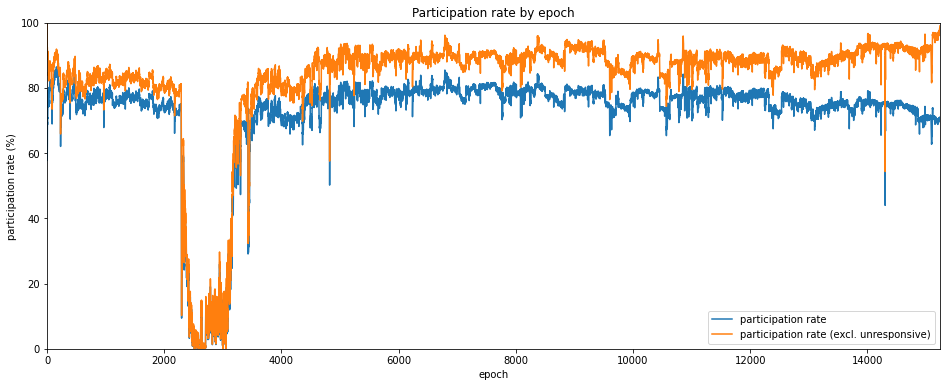

In [5]:
# plot participation rate

participation_rate_series = pd.Series(participation_rate)

participation_rate_reduced_series = pd.Series(participation_rate_reduced)

fig=plt.figure(figsize=(16,6))
plt.plot(participation_rate_series, label='participation rate')
plt.plot(participation_rate_reduced_series, label='participation rate (excl. unresponsive)')
plt.margins(0,0)
plt.title('Participation rate by epoch')
plt.xlabel('epoch')
plt.ylabel('participation rate (%)')
plt.legend(loc='lower right')
plt.show()

## Mean inclusion distance
Another metric we can use to look at the health of the network is how quickly validators are able to have their attestations included into the beacon chain. As mentioned above, this is called the *inclusion distance*, which is the number of slots it takes for an attestatation to be included in a canonical block. By averaging this across all validators who successfully attested in a given epoch, we get a quantity called the *mean inclusion distance*.

One advantage of this measure is that it is not directly affected by the presence unresponsive validators, since only attestations which are acually included contribute.

Unsurprisingly, the mean inclusion distance jumps significantly around the roughtime incident. But interestingly there are a number of smaller spikes, some (but not all) of which match downward spikes in the participation rate.

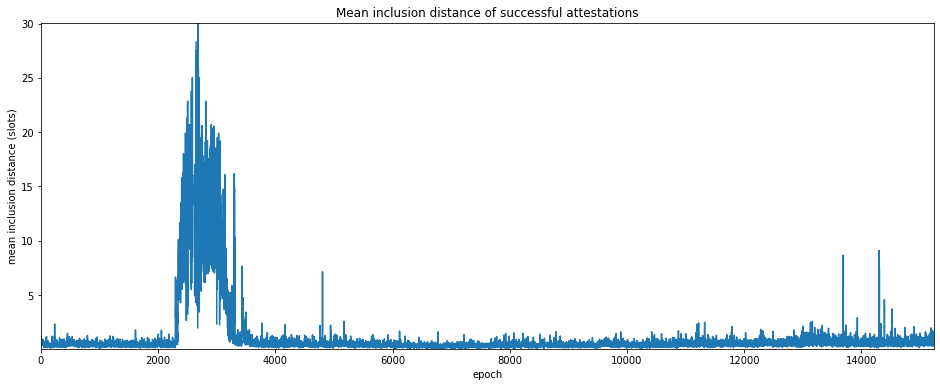

In [6]:
# graphs and stats for mean inclusion distance

mid_series = pd.Series(mean_inclusion_distance)

# plot the mean inclusion distance
fig=plt.figure(figsize=(16,6))
plt.plot(mid_series, label='mean inclusion distance')
plt.margins(0,0)
plt.title('Mean inclusion distance of successful attestations')
plt.xlabel('epoch')
plt.ylabel('mean inclusion distance (slots)')
plt.show()

## Attestation Effectiveness
A metric that combines participation rate and inclusion distance into a single score describing a validator's performance is *attestation effectiveness*, $E_a$ which has been defined by [Jim McDonald](https://www.attestant.io/posts/defining-attestation-effectiveness/) as the ratio between the minimum possible delay for inclusion of an attestation, and the actual delay:

$$ E_a = \frac{S_n-S_a}{S_i-S_a} $$

Where $S_n$ is then next slot containing a block, $S_a$ is the slot number being attested to, and $S_i$ is the slot at which the attestation was actually included. In the best case, the attestation is included at the next possible slot, i.e. $S_i=S_n$ and the attestation effectiveness $E_a=1$. If no attestation is included then $E_a=0$. In effect then, inclusion delay is measured from the next slot containing a canonical block, since empty slots will cause attestations to be delayed through no fault of the validator.

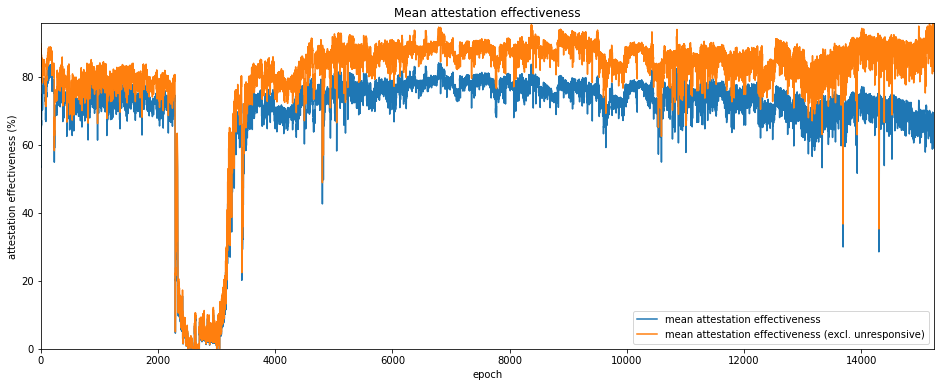

In [7]:
# plot attestation effectiveness

mean_ae_series = pd.Series(mean_ae)

mean_ae_reduced_series = pd.Series(mean_ae_reduced)

# plot the mean inclusion distance
fig=plt.figure(figsize=(16,6))
plt.plot(mean_ae_series, label='mean attestation effectiveness')
plt.plot(mean_ae_reduced_series, label='mean attestation effectiveness (excl. unresponsive)')
plt.margins(0,0)
plt.title('Mean attestation effectiveness')
plt.xlabel('epoch')
plt.ylabel('attestation effectiveness (%)')
plt.legend(loc='lower right')
plt.show()

## Attestation Accuracy
A subtler measure of attestation performance may be descibred as *attestation accuracy*. In this case we are interested in whether each validator attested to the correct *head root* at each slot.

By *correct* here, we mean that given an attestation for slot $S_a$, the head root chosen is:
1. canonical;
2. the most recent canonical block up to and including slot $S_a$.

So for example if a validator votes for a block in slot $S_a-1$, having not received any block in slot $S_a$ (due to network latency or other problems), but a block for slot $S_a$ later *does* become part of the finalised chain, then the validator can be said to have attested *incorrectly*. This is true even though the block to which they attested was itself canonical, and *was* at the chain head to the best of that validator's knowledge at time of attestation. Validators who attest incorrectly to the chain head receive no reward for that aspect of their attestation.

As in the case of mean inclusion distance, we are concerned only with attestations which were included in the canonical chain, so there is no difference from excluding unresponsive validators.

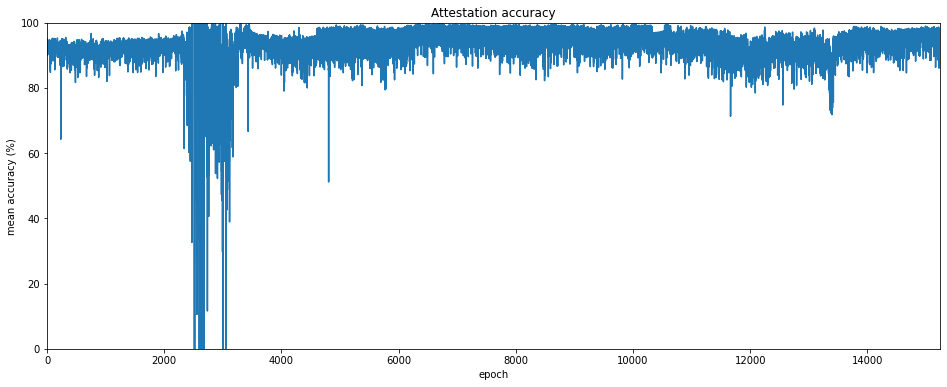

In [8]:
# plot accuracy rate by epoch

accuracy_series = pd.Series(accuracy)

# plot accuracy
fig=plt.figure(figsize=(16,6))
plt.plot(accuracy_series)
plt.margins(0,0)
plt.title('Attestation accuracy')
plt.xlabel('epoch')
plt.ylabel('mean accuracy (%)')
plt.show()

## Block Production Metrics (Empty Slots and Orphaned Blocks)
Apart from validators' performance on their attestation duties, we can also look at how validators perform as block producers. According to the eth2 spec, one validator is selected to produce a block at each slot. However for various reasons the validator might fail to do so, or might produce a block that is invalid.

Another possibility is that the assigned validator does produce a block, but it does no propagate to the rest of the network quickly enough to be included in the canonical chain. This block is then descrined as "orphaned". Equivalently, the block is *non-canonical*, as it did not become part of the finalised chain.

The set of orphaned blocks is generally subjective — in theory there might be an orphaned block for every empty slot. In practice there will be slots for which no block was ever produced (for example because the validator assigned to produce it was unresponseive). The orphaned blocks included the `chaind` database are those which were available to the beacon node which collected them. Different nodes in different parts of the network may have been able to collect other orphaned blocks which ultimately were not propagated throughout the whole network.

Nonetheless, counts of both empty slots and orphaned blocks can serve as another metric for network health. Since a maximum of only 32 blocks is produced each epoch, these metrics are much coarser than the attestation metrics we considered above (by contrast thousands of attestations may be produced each epoch).

For empty slots, we can use look at the attestation duties to determine which validator had been assigned to produce a block. As with the previous metrics, we can then exclude unresponsive validators to see if this gives us a clearer picture.

In [9]:
# count orphaned blocks

cursor.execute("SELECT COUNT(*), SUM(f_canonical::int) FROM t_blocks")
n_blocks, n_canonical = cursor.fetchone()
n_orphaned = n_blocks - n_canonical
print(f"Dataset contains {n_blocks} blocks of which {n_orphaned} ({100*(n_orphaned/n_blocks):.1f}%) orphaned")

# count empty slots

cursor.execute("SELECT COUNT(*) FROM t_blocks WHERE f_canonical")
n_empty = n_slots - cursor.fetchone()[0]
print(f"Dataset encompases {n_slots} slots of which {n_empty} ({100*(n_empty/n_slots):.1f}%) were empty")

Dataset contains 358048 blocks of which 8192 (2.3%) orphaned
Dataset encompases 487601 slots of which 137745 (28.2%) were empty


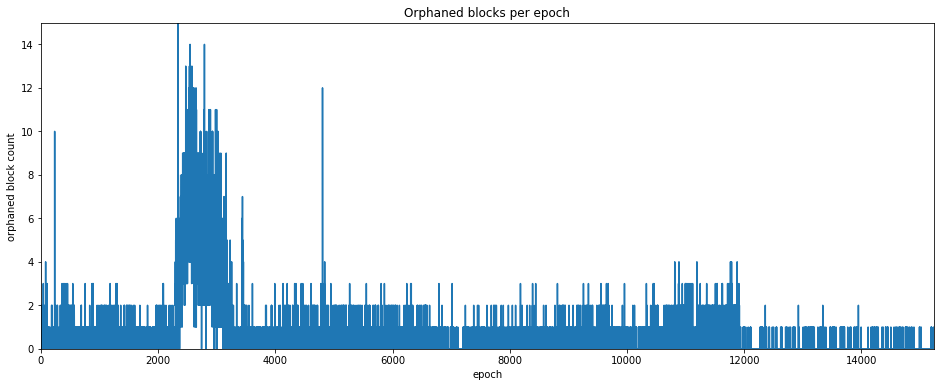

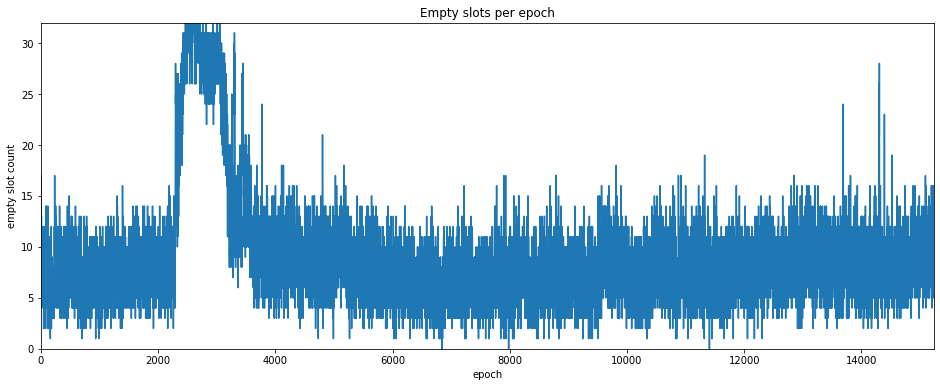

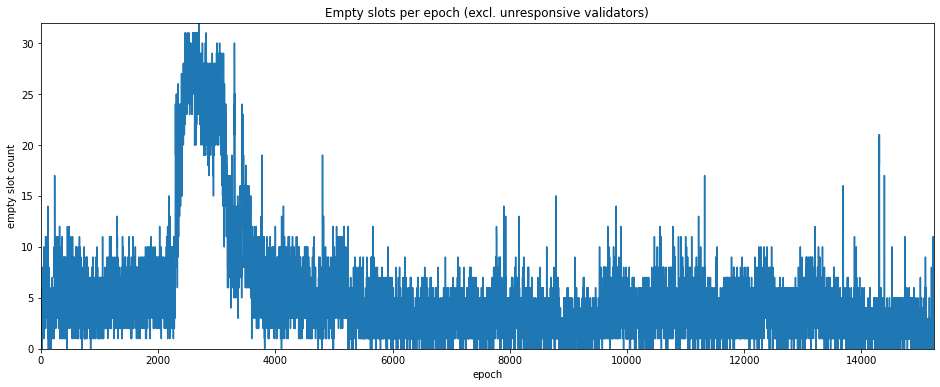

In [25]:
# plot empty slots and orphaned blocks by epoch

cursor.execute("SELECT f_slot FROM t_blocks WHERE NOT f_canonical")
result = cursor.fetchall()
orphaned_count = [0] * n_epochs
for el in result:
    orphaned_count[el[0] // 32] += 1
    
orphaned_blocks_series = pd.Series(orphaned_count)

# plot orphan count
fig=plt.figure(figsize=(16,6))
plt.plot(orphaned_blocks_series)
plt.margins(0,0)
plt.title('Orphaned blocks per epoch')
plt.xlabel('epoch')
plt.ylabel('orphaned block count')
plt.show()

empty_slots = [True] * n_slots
cursor.execute("SELECT f_slot FROM t_blocks WHERE f_canonical")
result = cursor.fetchall()
for el in result:
    empty_slots[el[0]] = False

empty_count = [0] * n_epochs
for slot in range(0, n_epochs * 32, 32):
    empty_count[slot // 32] = sum(empty_slots[slot:slot+32])
    
empty_count_series = pd.Series(empty_count)

# plot empty count
fig=plt.figure(figsize=(16,6))
plt.plot(empty_count_series)
plt.margins(0,0)
plt.title('Empty slots per epoch')
plt.xlabel('epoch')
plt.ylabel('empty slot count')
plt.show()

# repeat empty slot analysis but ignore unresponsive proposers

cursor.execute("SELECT f_slot, f_validator_index FROM t_proposer_duties")
result = cursor.fetchall()
proposer_responsive = [False] * n_slots
for el in result:
    slot = el[0]
    if slot > latest_slot:
        continue
    epoch = slot // 32
    validator = validators[el[1]]
    if epoch >= validator["first_attestation"] and epoch <= validator["latest_attestation"]:
        proposer_responsive[slot] = True

empty_slots_responsive = [empty and proposer_responsive[i] for i, empty in enumerate(empty_slots)]

empty_responsive_count = [0] * n_epochs
for slot in range(0, n_epochs * 32, 32):
    empty_responsive_count[slot // 32] = sum(empty_slots_responsive[slot:slot+32])
    
empty_count_reduced_series = pd.Series(empty_responsive_count)

# plot empty (responsive) count
fig=plt.figure(figsize=(16,6))
plt.plot(empty_count_reduced_series)
plt.margins(0,0)
plt.title('Empty slots per epoch (excl. unresponsive validators)')
plt.xlabel('epoch')
plt.ylabel('empty slot count')
plt.show()

## Slashing Events
The final indicator we will consider in this article is the occurence of slashing events. Slashing occurs when a validator provably misbehaves, for example by attesting to two different blocks in the same slot. Slashing results in the offending validator losing a significant proportion of its stake and then being immediately ejected from the set. The number of slashing events occuring in each epoch is plotted below.

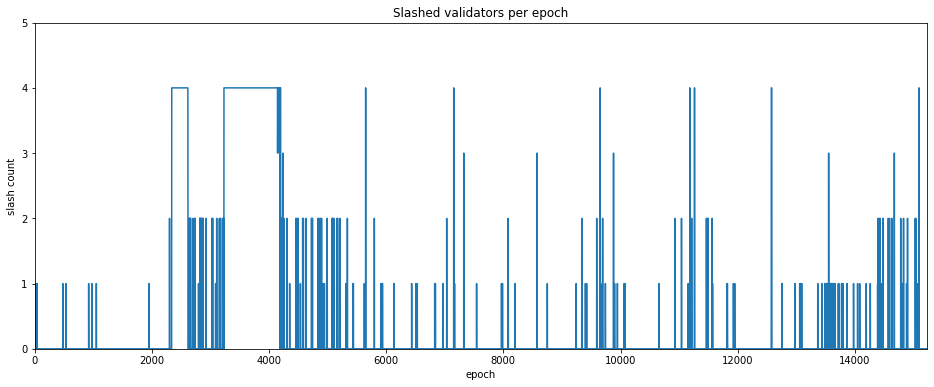

In [15]:
# count up slashing events, plot per epoch

slashed_count = [0] * n_epochs
slashed_epochs = [v["exit_epoch"] for v in validators if v["slashed"]]
for epoch in slashed_epochs:
        slashed_count[epoch] += 1
    
slashed_count_series = pd.Series(slashed_count)
    
# plot slashed count
fig=plt.figure(figsize=(16,6))
plt.plot(slashed_count_series)
plt.margins(0,0)
plt.title('Slashed validators per epoch')
plt.xlabel('epoch')
plt.ylabel('slash count')
plt.yticks(range(6))
plt.show()

In this plot we see the increased frequency of slashing events which occurred during the roughtime incident. This may have been caused by users switching clients quickly and therefore attesting more than once for the same slot, or possibly due to client bugs. However, outside of this period no obvious pattern of slashing events is evident. We will therefore not look at this indicator any further for this article.

## Baselining
We can use the metrics identified to highlight other periods of network stress which may warrant closer attention. One way of doing this is to baseline the metrics on a period believed to represent a healthy network, and then identify excursions a significant distance from this baseline. Since the "reduced" versions of the metrics above (i.e. those which exclude unresponsive validators) appear to maintain a more consistent baseline, we will stick to those versions in this section. For our baseline, we calculate the mean and standard deviation for each metric over the period from epoch 6000 to epoch 9000. We then plot the normalised metrics below.

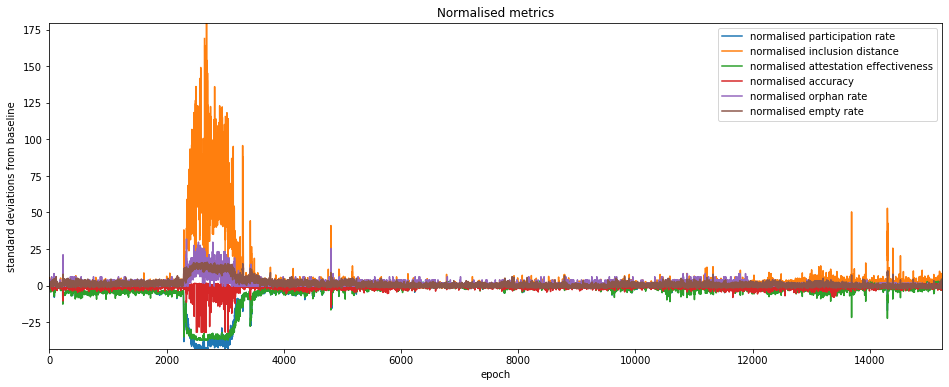

In [67]:
# get baselean mean and standard deviations for each metric
pr_mean = participation_rate_reduced_series.iloc[6000:9000].mean()
pr_std  = participation_rate_reduced_series.iloc[6000:9000].std()
id_mean = mid_series.iloc[6000:9000].mean()
id_std  = mid_series.iloc[6000:9000].std()
ae_mean = mean_ae_reduced_series.iloc[6000:9000].mean()
ae_std  = mean_ae_reduced_series.iloc[6000:9000].std()
ac_mean = accuracy_series.iloc[6000:9000].mean()
ac_std  = accuracy_series.iloc[6000:9000].std()
ob_mean = orphaned_blocks_series.iloc[6000:9000].mean()
ob_std  = orphaned_blocks_series.iloc[6000:9000].std()
es_mean = empty_count_reduced_series.iloc[6000:9000].mean()
es_std  = empty_count_reduced_series.iloc[6000:9000].std()

pr_norm = (participation_rate_reduced_series - pr_mean) / pr_std
id_norm = (mid_series                        - id_mean) / id_std
ae_norm = (mean_ae_reduced_series            - ae_mean) / ae_std
ac_norm = (accuracy_series                   - ac_mean) / ac_std
ob_norm = (orphaned_blocks_series            - ob_mean) / ob_std
es_norm = (empty_count_reduced_series        - es_mean) / es_std

# plot normalised metrics
fig=plt.figure(figsize=(16,6))
plt.plot(pr_norm, label='normalised participation rate')
plt.plot(id_norm, label='normalised inclusion distance')
plt.plot(ae_norm, label='normalised attestation effectiveness')
plt.plot(ac_norm, label='normalised accuracy')
plt.plot(ob_norm, label='normalised orphan rate')
plt.plot(es_norm, label='normalised empty rate')
plt.margins(0,0)
plt.title('Normalised metrics')
plt.xlabel('epoch')
plt.ylabel('standard deviations from baseline')
plt.legend(loc='upper right')
plt.show()

Once again, the roughtime incident dominates the plot, but a number of other spikes are apparent. For these the normalised inclusion distance appears to be the most sensitive (or possibly noisy) metric, while the orphan/empty rates appear to be less descriptive. Since 1-per-slot metrics are much coarser, we will eliminate them from the next analysis section. Meanwhile, since attestation effectiveness combines participation rate and mean inclusion distance, we will allow it to stand for all three. This leaves us with two metrics which we can use to look for anomalies:

- normalised attestation effectiveness
- noramlised accuracy

They are plotted on their own below for greater clarity.

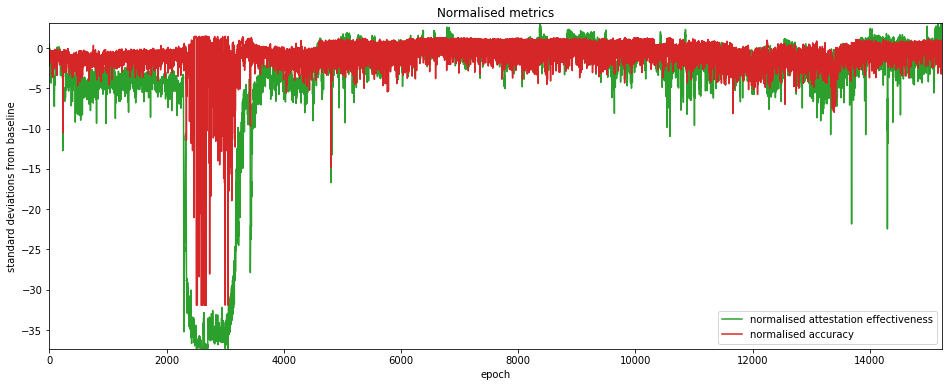

In [66]:
# plot normalised metrics
fig=plt.figure(figsize=(16,6))
plt.plot(ae_norm, label='normalised attestation effectiveness', color='tab:green')
plt.plot(ac_norm, label='normalised accuracy', color='tab:red')
plt.margins(0,0)
plt.title('Normalised metrics')
plt.xlabel('epoch')
plt.ylabel('standard deviations from baseline')
plt.legend(loc='lower right')
plt.show()

## Anomaly Detection
Having chosen our metrics for identifying anomalies we can now run a very simple anomaly detection algorithm to find the 'spikes' of interest. We report any epoch where either of the two metrics (effectiveness/accuracy) is more than 10 standard devations from the baseline. We will start from epoch 4000 to exclude the roughtime incident.

Results are shown in the table below, which appears to show that attestation effectiveness is a more sensitive metric. However, for one of the anomalies (epoch 4805), the attestation accuracy deviated almost as far.

In [63]:
# basic anomaly detection over attestation effectiveness and accuracy

sensitivity = 10
print("epoch effectiveness accuracy")
for epoch in range(4000,n_epochs):
    if abs(ae_norm.iloc[epoch]) > sensitivity or abs(ac_norm.iloc[epoch]) > sensitivity:
        print(f"{epoch}".rjust(5), f"{ae_norm.iloc[epoch]:.1f}".rjust(9), f"{ac_norm.iloc[epoch]:.1f}".rjust(9))

epoch effectiveness accuracy
 4805     -16.7     -14.9
 4822     -13.3      -1.0
10591     -11.0       0.3
13334     -10.7      -2.3
13690     -12.4       0.5
13691     -21.8       0.7
13932     -10.8      -0.3
14302     -22.5       0.6
14303     -15.7      -1.8
14305     -10.2      -0.6
14308     -11.9       0.3


## Conclusions
In this article, we've seen how network conditions can impact on a range of metrics derived from eth2 client data. We've also seen how these metrics could be used for anomaly detection, to highlight periods of increased stress, and perhaps hint at their causes. In particular, we found that the attestation effectiveness and attestation accuracy sometimes seemed to contain complementary information about types of network stress.

To understand exactly what was happening for each of these anomalous epochs, it would be necessary to look in much more detail about what was happening slot by slot for each of the metrics (and perhaps consider additional information), which could be the subject of a future article.

## Ackowledgement
Many thanks to [Barnabé Monnot](https://twitter.com/barnabemonnot) for helping me get attestation accuracy right.